# Plynty Bureau of Labor Statistics Consumer Expenditure Analysis

[BLS Comsumer Expenditure Survey](https://www.bls.gov/cex/home.htm)

[Interview Data Dictionary](https://www.bls.gov/cex/2015/csxintvwdata.pdf)

[Diary Data Dictionary](https://www.bls.gov/cex/2015/csxdiarydata.pdf)

### Where to download the BLS CE PUMD
- The zip files download automatically
- To download the Stub files open the links then right click and choose "Save As..."

[2015 interview zip file](https://www.bls.gov/cex/pumd/data/comma/intrvw15.zip)

[2015 diary zip file](https://www.bls.gov/cex/pumd/data/comma/diary15.zip)

[2015 IntStub file](https://www.bls.gov/cex/pumd/2014/csxintstub.txt)

[2015 IStub file](https://www.bls.gov/cex/pumd/2014/csxistub.txt)

[2015 DStub file](https://www.bls.gov/cex/pumd/2014/csxdstub.txt)

### This Scripts Goals for Plynty
- Create an easy to use analysis script for the BLS CE PUMD 
- Create a csv files that has average percentages spent on plynty categories for certain income classes
- Develop a 
- Create incomeclasses that are stastically significant

##### Importing Libraries 

In [45]:
import pandas as pd
import numpy as np
import os
import subprocess
import math
import matplotlib.pyplot as plt
from scipy.interpolate import *
from plyntywidgets import *
from blsFunctions import *
print("Dependencies Loaded...")

Dependencies Loaded...


### Setting Parameters
- year: the last two number associated with the year of the data
    for example for data from 2015: year = "15"
- minAge: the low bound (inclusive) of the age range you wish to subset by
- maxAge: the high bound (inclusive) of the age range you wish to subset by
- incomeBrackets: array of numbers that you wish to create the new income classes
    the bracketing works as follows (1,2], (2,3], (3,4]
- filesToRead: the strings of the abbreviations associated with the files you wish to read
    options are: "all", "diary", "interview", "dtbd", "expd", "fmld", "memd", "fmli", "itbi", "memi", "mtbi", "ntaxi"

In [46]:
year = "15"
filesToRead = ["fmli", "mtbi"]
incomeBrackets = [-math.inf,11000,20000,30000,43000,55000,69000,80000,100000,120000,150000,200000,250000,300000,math.inf]
minAge = 65
maxAge = 103

### Setting Directory locations and FileNames on your Local Machine

In [47]:
# directory in which the diary and interview folders are held is located
diaryDir = "/Users/adyke/Vizuri/CE_PUMD/diary15/"
interviewDir = "/Users/adyke/Vizuri/CE_PUMD/intrvw15/"

# Directory where stubfiles are located
pathToStubFileDir = "/Users/adyke/Vizuri/Stubfiles/"
rScriptStubfilePathAndName = "/Users/adyke/Vizuri/BLS_Python_Analysis/creatingStubCsvs.R"

# Filenames of the Stubfiles
IStubFileName = "IStub2015.txt"
DStubFileName = "DStub2015.txt"
IntStubFileName = "IntStub2015.txt"

# name of interview dir within the interview dir
insideIntrvwDirName = "intrvw"

# name of the directory where you want the output percentages csv
outputDir = "/Users/adyke/Vizuri/outputFiles/"

### Reading in the files specified by FilesToRead

In [48]:
if(len(filesToRead)==0):
    print("The files to read variable is empty.")

# looping through each file to read
for file in filesToRead:
    if file == "dtbd" or file == "all" or file == "diary":
        dtbd = readFileSet("dtbd", diaryDir)
    if file == "expd" or file == "all" or file == "diary":
        expd = readFileSet("expd", diaryDir)
    if file == "fmld" or file == "all" or file == "diary":
        fmld = readFileSet("fmld", diaryDir)
    if file == "memd" or file == "all" or file == "diary":
        memd = readFileSet("memd", diaryDir)
    if file == "fmli" or file == "all" or file == "interview":
        fmli = readFileSet("fmli", interviewDir+insideIntrvwDirName+year+"/")
    if file == "itbi" or file == "all" or file == "interview":
        itbi = readFileSet("itbi", interviewDir+insideIntrvwDirName+year+"/")
    if file == "itii" or file == "all" or file == "interview":
        itii = readFileSet("itii", interviewDir+insideIntrvwDirName+year+"/")
    if file == "memi" or file == "all" or file == "interview":
        memi = readFileSet("memi", interviewDir+insideIntrvwDirName+year+"/")
    if file == "mtbi" or file == "all" or file == "interview":
        mtbi = readFileSet("mtbi", interviewDir+insideIntrvwDirName+year+"/")
        mtbi.UCC = mtbi.UCC.astype(str)
    if file == "ntaxi" or file == "all" or file == "interview":
        ntaxi = readFileSet("ntaxi", interviewDir+insideIntrvwDirName+year+"/")
# does not read form the expn or para subdirectories


### Using R to convert the Stub files into csv files

In [49]:
if os.path.isfile(pathToStubFileDir+"DStub.csv") and os.path.isfile(pathToStubFileDir+"IStub.csv") and os.path.isfile(pathToStubFileDir+"IntStub.csv"):
    print("Stubfiles Exist")
else:
    # converting the stub files via R 
    subprocess.call("Rscript "+rScriptStubfilePathAndName+" "+pathToStubFileDir+" "+IStubFileName+" "+DStubFileName+" "+IntStubFileName, shell=True)
    print("Stubfile Csvs created in "+pathToStubFileDir)

Stubfiles Exist


### Reading and Cleaning the stubfile CSVs into pandas dataframes

In [50]:
# reading in the stubfiles
DStub = pd.read_csv(pathToStubFileDir+"DStub.csv")
IStub = pd.read_csv(pathToStubFileDir+"IStub.csv")
IntStub = pd.read_csv(pathToStubFileDir+"IntStub.csv")

# removing the index from the stufile
DStub = DStub.drop(DStub.columns[0], axis=1)
IStub = IStub.drop(IStub.columns[0], axis=1)
IntStub = IntStub.drop(IntStub.columns[0], axis=1)

# replacing * with 0 in the level columns
DStub.loc[DStub.level == "*", 'level'] = 0
IStub.loc[IStub.level == "*", 'level'] = 0
IntStub.loc[IntStub.level == "*", 'level'] = 0

# Starting the Plynty calculations

### Creating the UCC roll ups for Plynty

In [51]:
# creating UCC rollups for the interview files for plynty categories
iTotalExp = categoricalUCCRollUp(IStub,["TOTALE"])
iFoodAtHome = categoricalUCCRollUp(IStub, ["FOODHO", "ALCHOM"])
iFoodAway = categoricalUCCRollUp(IStub, ["FOODAW", "ALCAWA"])
iHousing = categoricalUCCRollUp(IStub, ["HOUSIN"], ignoreUCCs = categoricalUCCRollUp(IStub, ["UTILS"]))
iUtilites = categoricalUCCRollUp(IStub, ["UTILS"])
iClothingAndBeauty = categoricalUCCRollUp(IStub, ["APPARE","PERSCA"])
iTransportation = categoricalUCCRollUp(IStub, ["TRANS"])
iHealthcare = categoricalUCCRollUp(IStub, ["HEALTH"])
iEntertainment = categoricalUCCRollUp(IStub, ["ENTRTA","READIN"])
iMiscellaneous = categoricalUCCRollUp(IStub, ["MISC","TOBACC"])
iCharitableAndFamilyGiving = categoricalUCCRollUp(IStub, ["CASHCO"])
iInsurance = categoricalUCCRollUp(IStub, ["LIFEIN"])
iEducation = categoricalUCCRollUp(IStub, ["EDUCAT"])
iHousingPrinciple = categoricalUCCRollUp(IStub,["MRTPRI"])

### Adding and Rolling up the MTBI Categories into mtbiRolledUp

outputs from cell:
- mtbiTrimmed: Dataframe with NewID, TotatlExp and each entry of cost.

In [52]:
rollupNames = ["iTotalExp","iFoodAtHome","iFoodAway","iHousing","iUtilites","iClothingAndBeauty","iTransportation","iHealthcare","iEntertainment","iMiscellaneous","iCharitableAndFamilyGiving","iInsurance","iEducation","iHousingPrinciple"]
rollups = [iTotalExp,iFoodAtHome,iFoodAway,iHousing,iUtilites,iClothingAndBeauty,iTransportation,iHealthcare,iEntertainment,iMiscellaneous,iCharitableAndFamilyGiving,iInsurance,iEducation,iHousingPrinciple]

mtbiRolledUp = rollUpDataframe(mtbi, rollupNames, rollups, negativeColumns=["iHousingPrinciple"], multiple=4)

mtbiTrimmed = mtbiRolledUp.loc[: , ['NEWID','iTotalExp','iFoodAtHome','iFoodAway','iHousing','iUtilites','iClothingAndBeauty','iTransportation','iHealthcare','iEntertainment','iMiscellaneous','iCharitableAndFamilyGiving','iInsurance','iEducation','iHousingPrinciple']]

### Creating the Sum for all expenditure category columns for each NEWID
nonZeroColumns is an array that contains the names of columns that should not be Zero

outputs from cell:
- iExpensesByNewID: total expenses for each category for each NewID

In [53]:
# adding up all columns for each new id
iExpensesByNewID = mtbiTrimmed.groupby(['NEWID'],as_index=False).sum()
# removing rows with zero values in key categories
nonZeroColumns = ['iFoodAtHome','iFoodAway','iHousing','iUtilites']
for column in nonZeroColumns:
    iExpensesByNewID = iExpensesByNewID[iExpensesByNewID[column] != 0]
iExpensesByNewID['iHousing'] = iExpensesByNewID['iHousing']+iExpensesByNewID['iHousingPrinciple']

### Subestting FMLI for age and recoding the incomebrackets

In [54]:
# subsetting for the age bracket
fmliAge = subsetDataframe(dataframe=fmli, columnName="AGE_REF", minValue=minAge, maxValue=maxAge)
fmliAge = fmliAge.reset_index()

# recoding the income brackets
fmliRecoded = binColumn(dataframe=fmliAge, toBinColumnName="FINCBTXM", binValues=incomeBrackets, binnedColumnName="INCLASS", labels=range(1,len(incomeBrackets)))

### Adding the Income class colum to the ExpensesByNewID dataframe

In [55]:
# combining the fmli and iExpensesByNewID
inclassExpenses = pd.merge(left=fmliRecoded[['NEWID','INCLASS','FINCBTXM']],right=iExpensesByNewID, on=['NEWID'])
# inclassExpenses

### Averaging the expenditures based on incomebrackets
inclassAverages is average money spent for each incomeclass

In [56]:
# getting mean for all columns with the same income class besides newId and creating new dataframe
inclassAverages = round(inclassExpenses.ix[: ,inclassExpenses.columns != 'NEWID'].groupby(['INCLASS'],as_index=False).mean(),2)
# inclassAverages

### Converting the Average expenditures for income classes into percentages of expenditures
percentages is the percent of total expenditure for each category for each incomeclass 

In [57]:
# creating new dataframe for the percentages that only includes the plynty categories
percentages = inclassAverages.loc[:,rollupNames[1:]]
for column in rollupNames[1:]:
    percentages[column] = inclassAverages[column]/inclassAverages.iTotalExp
percentages['ExpInc'] = inclassAverages['iTotalExp']/inclassAverages['FINCBTXM']

# truncate the max ExpInc
percentages.ExpInc.ix[percentages['ExpInc']>1] = 1

# percentages

# Exploring Issues in the data

### Getting Description of the inclassExpenses dataframe

In [58]:
# max and min of housing per income class
rowDescription = []
for inclass in range(1,len(incomeBrackets)):
    rowDescription.append(inclassExpenses.iHousing.loc[inclassExpenses.INCLASS == inclass].describe())
descriptions = pd.concat(rowDescription, axis=1)
descriptions.columns = range(0,len(incomeBrackets)-1)
descriptions = descriptions.transpose()
descriptions

,count,mean,std,min,25%,50%,75%,max
0,326.0,8564.438650,10062.339852,4.0,2355.00,5012.0,10810.00,75037.0
1,899.0,8315.601780,11580.208517,30.0,2500.00,4924.0,9508.00,181360.0
2,985.0,9401.238579,10665.999879,-11880.0,2664.00,6060.0,11628.00,108669.0
3,934.0,10443.471092,10614.518580,-22664.0,3886.50,7424.0,13206.00,105052.0
4,559.0,11955.203936,10870.384354,108.0,4856.00,9028.0,16154.00,94860.0
5,410.0,13494.765854,13209.720043,520.0,5380.00,10190.0,16789.00,94484.0
6,253.0,15626.007905,12799.732312,820.0,6968.00,12372.0,19628.00,80816.0
7,343.0,17504.518950,15544.065390,500.0,7844.00,12744.0,22864.00,107284.0
8,245.0,19497.697959,20934.078324,4.0,7204.00,13924.0,24424.00,170024.0
9,162.0,24625.740741,24992.016914,2028.0,10081.00,18130.0,30860.00,140110.0


### Removing outliers in iHousing
 - For each income class
    - Find Q1 and Q3
    - Calculate IQR
    - Find rows outside of Q3/Q2 +/- (1.5 x IQR) and Q3/Q2 +/- (3 x IQR)
 - Remove Rows from Dataframe
 - Clean1: Inner Fence
 - Clean2: Outer Fence

In [59]:
# cleaning the inclassExpenses dataframe of outliers
outliers1 = inclassExpenses.copy()


outliers1
innerFence = []
outerFence = []


print("There are "+str(len(inclassExpenses))+" rows before removal of outliers")

for inclass in range(1,len(incomeBrackets)):
    outliers1InClass = outliers1.where(outliers1['INCLASS']==inclass)
    Q1 = outliers1InClass['iHousing'].quantile(0.25)
    Q3 = outliers1InClass['iHousing'].quantile(0.75)
    IQR = Q3 - Q1
    innerFence.extend(outliers1InClass[outliers1InClass['iHousing'] < (Q1 - (1.5 * IQR))].index.tolist())
    innerFence.extend(outliers1InClass[outliers1InClass['iHousing'] > (Q3 + (1.5 * IQR))].index.tolist())    
    outerFence.extend(outliers1InClass[outliers1InClass['iHousing'] < (Q1 - (3 * IQR))].index.tolist())
    outerFence.extend(outliers1InClass[outliers1InClass['iHousing'] > (Q3 + (3 * IQR))].index.tolist())


clean1 = outliers1.drop(outliers1.index[innerFence])
clean1
clean2 = outliers1.drop(outliers1.index[outerFence])
clean2

print("Removed "+str(len(innerFence))+ " rows deemed to be out of inner fence")
print("Removed "+str(round(len(innerFence)/len(inclassExpenses)*100,2))+ "% of the CUs")

print("Removed "+str(len(outerFence))+ " rows deemed to be out of inner fence")
print("Removed "+str(round(len(outerFence)/len(inclassExpenses)*100,2))+ "% of the CUs")

# creating the descriptions for the cleaned outlier dataframe
rowDescription1 = []
for inclass in range(1,len(incomeBrackets)):
    rowDescription1.append(clean1.iHousing.loc[clean1.INCLASS == inclass].describe())
descriptions1 = pd.concat(rowDescription1, axis=1)
descriptions1.columns = range(0,len(incomeBrackets)-1)
descriptions1 = descriptions1.transpose()
# descriptions1

There are 5388 rows before removal of outliers
Removed 357 rows deemed to be out of inner fence
Removed 6.63% of the CUs
Removed 143 rows deemed to be out of inner fence
Removed 2.65% of the CUs


### Looking at the outliers that were removed

In [60]:
innerOutliers = inclassExpenses.copy()
innerOutliers = innerOutliers.ix[innerFence,:]
print("Number of outliers in each income class: "+str(innerOutliers.INCLASS.value_counts().values))
innerOutliers.head()

Number of outliers in each income class: [74 71 56 26 25 24 19 18 15 10  7  5  5  2]


,NEWID,INCLASS,FINCBTXM,iTotalExp,iFoodAtHome,iFoodAway,iHousing,iUtilites,iClothingAndBeauty,iTransportation,iHealthcare,iEntertainment,iMiscellaneous,iCharitableAndFamilyGiving,iInsurance,iEducation,iHousingPrinciple
525,3057932,1,6155.0,97470.8,5500.0,7080.0,25912.0,4092.0,920.0,34452.0,14506.8,2844.0,0.0,4400.0,0.0,0.0,2236.0
590,3066713,1,7900.0,114605.6,5544.0,20448.0,27100.0,5420.0,4280.0,17788.0,5005.6,13860.0,360.0,14800.0,0.0,0.0,0.0
1194,3000783,1,2615.0,53130.8,5720.0,4040.0,29552.0,9656.0,960.0,5320.0,2618.8,6236.0,340.0,660.0,0.0,0.0,11972.0
1314,3057933,1,6155.0,101969.6,5436.0,4492.0,40720.0,6060.0,1640.0,18032.0,16593.6,6260.0,0.0,4800.0,0.0,0.0,2064.0
1509,3093291,1,-3143.0,61838.8,4500.0,5320.0,26032.0,3796.0,864.0,2396.0,17214.8,1200.0,3440.0,100.0,0.0,0.0,3024.0


In [61]:
outerOutliers = inclassExpenses.copy()
outerOutliers = outerOutliers.ix[outerFence,:]
print("Number of outliers in each income class: "+str(outerOutliers.INCLASS.value_counts().values))
outerOutliers.head()

Number of outliers in each income class: [39 29 19 14 10  7  6  6  4  4  3  1  1]


,NEWID,INCLASS,FINCBTXM,iTotalExp,iFoodAtHome,iFoodAway,iHousing,iUtilites,iClothingAndBeauty,iTransportation,iHealthcare,iEntertainment,iMiscellaneous,iCharitableAndFamilyGiving,iInsurance,iEducation,iHousingPrinciple
1314,3057933,1,6155.0,101969.6,5436.0,4492.0,40720.0,6060.0,1640.0,18032.0,16593.6,6260.0,0.0,4800.0,0.0,0.0,2064.0
1581,3100251,1,10859.0,69720.0,1300.0,780.0,48908.0,2148.0,440.0,10712.0,6992.0,948.0,0.0,600.0,0.0,0.0,3108.0
1643,3105982,1,10536.0,723291.8,8500.0,3600.0,75037.0,8148.0,3280.0,2600.0,31578.8,10424.0,0.0,600000.0,0.0,0.0,19876.0
1868,3170291,1,9310.0,67181.6,7520.0,1980.0,45476.0,5456.0,936.0,9916.0,5277.6,1428.0,0.0,3120.0,0.0,0.0,13928.0
1937,2908235,1,6249.2,48750.8,1560.0,1560.0,38928.0,1020.0,160.0,1972.0,1450.8,1080.0,0.0,1020.0,0.0,0.0,0.0


### Things learned from removing outliers
- Removing outliers helped some of the standard deviation crazyness
- Higher incomebrackets have greater standard deviation even without outliers

### Creating the percentage output for cleaned dataframe

In [62]:
# creating percentage outputs for cleaned dataframe
inclassCleanAverages1 = round(clean1.ix[: ,clean1.columns != 'NEWID'].groupby(['INCLASS'],as_index=False).mean(),2)
# creating new dataframe for the percentages that only includes the plynty categories
cleanPercentages1 = inclassCleanAverages1.loc[:,rollupNames[1:]]
for column in rollupNames[1:]:
    cleanPercentages1[column] = inclassCleanAverages1[column]/inclassCleanAverages1.iTotalExp
cleanPercentages1['ExpInc'] = inclassCleanAverages1['iTotalExp']/inclassCleanAverages1['FINCBTXM']
# truncate the max ExpInc
cleanPercentages1.ExpInc.ix[cleanPercentages1['ExpInc']>1] = 1
cleanPercentages1

,iFoodAtHome,iFoodAway,iHousing,iUtilites,iClothingAndBeauty,iTransportation,iHealthcare,iEntertainment,iMiscellaneous,iCharitableAndFamilyGiving,iInsurance,iEducation,iHousingPrinciple,ExpInc
0,0.146568,0.063419,0.262497,0.114159,0.024628,0.120243,0.146389,0.047758,0.034899,0.053213,0.004312,0.002314,0.020399,1.000000
1,0.142195,0.067169,0.243816,0.121069,0.027098,0.145056,0.142188,0.052605,0.019704,0.046667,0.008785,0.001579,0.017930,1.000000
2,0.129031,0.066665,0.220186,0.107430,0.025888,0.156972,0.175955,0.059004,0.014489,0.054208,0.005172,0.002872,0.017872,1.000000
3,0.128421,0.069438,0.230440,0.104732,0.024794,0.165617,0.161829,0.051035,0.020328,0.054545,0.008613,0.003266,0.023058,1.000000
4,0.120986,0.063269,0.244195,0.098072,0.028459,0.180962,0.155340,0.055792,0.017767,0.054812,0.008788,0.003763,0.032207,0.869423
5,0.114965,0.064815,0.234107,0.086921,0.027427,0.178446,0.152244,0.055489,0.019535,0.085100,0.007528,0.002164,0.028741,0.759940
6,0.106793,0.067175,0.249099,0.085850,0.037168,0.179637,0.157164,0.056925,0.014295,0.063639,0.007508,0.001677,0.026931,0.693927
7,0.105498,0.064117,0.261285,0.085970,0.026559,0.219591,0.133770,0.046440,0.019194,0.059541,0.008713,0.002939,0.033617,0.652244
8,0.091829,0.057008,0.214993,0.073602,0.030750,0.233272,0.118366,0.081294,0.017878,0.088012,0.006209,0.013971,0.027184,0.637829
9,0.092898,0.059023,0.266646,0.083929,0.028843,0.240467,0.108747,0.050183,0.012261,0.091278,0.010939,0.009401,0.054615,0.541989


In [63]:
# creating percentage outputs for cleaned dataframe
inclassCleanAverages2 = round(clean2.ix[: ,clean2.columns != 'NEWID'].groupby(['INCLASS'],as_index=False).mean(),2)
# creating new dataframe for the percentages that only includes the plynty categories
cleanPercentages2 = inclassCleanAverages2.loc[:,rollupNames[1:]]
for column in rollupNames[1:]:
    cleanPercentages2[column] = inclassCleanAverages2[column]/inclassCleanAverages2.iTotalExp
cleanPercentages2['ExpInc'] = inclassCleanAverages2['iTotalExp']/inclassCleanAverages2['FINCBTXM']
# truncate the max ExpInc
cleanPercentages2nonTruncated = cleanPercentages2.copy()
cleanPercentages2.ExpInc.ix[cleanPercentages2['ExpInc']>1] = 1
cleanPercentages2

,iFoodAtHome,iFoodAway,iHousing,iUtilites,iClothingAndBeauty,iTransportation,iHealthcare,iEntertainment,iMiscellaneous,iCharitableAndFamilyGiving,iInsurance,iEducation,iHousingPrinciple,ExpInc
0,0.142941,0.064822,0.278057,0.111856,0.024535,0.124034,0.141877,0.050384,0.032319,0.050914,0.004135,0.002125,0.027998,1.000000
1,0.137080,0.066246,0.263070,0.117938,0.026841,0.141163,0.141609,0.051443,0.018726,0.047159,0.008865,0.001984,0.022125,1.000000
2,0.124603,0.067042,0.239401,0.102627,0.026122,0.150944,0.171640,0.058019,0.013778,0.058661,0.004964,0.002809,0.020611,1.000000
3,0.126196,0.068054,0.250028,0.102665,0.024812,0.160038,0.160147,0.050828,0.019355,0.053810,0.008331,0.003177,0.027440,1.000000
4,0.117862,0.064672,0.258571,0.095006,0.028917,0.175919,0.152045,0.055538,0.017326,0.054973,0.008350,0.003513,0.032691,0.899778
5,0.112838,0.065943,0.249733,0.085270,0.026609,0.174707,0.147446,0.054308,0.018759,0.081443,0.009294,0.002029,0.028379,0.780844
6,0.102403,0.065898,0.275018,0.081352,0.035001,0.170428,0.148557,0.054527,0.013425,0.071825,0.006908,0.001512,0.026854,0.729271
7,0.103893,0.064589,0.279256,0.084223,0.026632,0.211942,0.131610,0.047932,0.018419,0.058803,0.008853,0.004122,0.040275,0.664773
8,0.089496,0.058028,0.241117,0.072025,0.030188,0.223320,0.116698,0.079314,0.018008,0.083366,0.005768,0.012906,0.030235,0.655455
9,0.090935,0.060259,0.279501,0.082913,0.030611,0.231787,0.107846,0.053889,0.011777,0.089655,0.010556,0.008911,0.058638,0.556878


In [64]:
plt.bar(cleanPercentages1.index, cleanPercentages1.ExpInc, color = 'b')
plt.title("Percent of Income Expended per Income Class")
plt.xlabel("Income Class")
plt.ylabel("Percentage")
# plt.show()

In [65]:
plt.bar(cleanPercentages1.index, cleanPercentages1.iHousing, color = 'b')
plt.ylim(0,.4)
plt.title("Percent spent on Housing per Income Class (without outliers)")
plt.xlabel("Income class")
plt.ylabel("Percent spent on housing")
# plt.show()

### Cell that determines how similar the neighbor rows are
Potentially use this to combine similar rows.
Can't figure out the correct statistical test to determine if rows are statistically similar

###### The higher the difference value the more different the rows are. (low values mean similar rows)

In [66]:
significance = 0.005
for row in range(len(cleanPercentages2)-1):
    print("Income Bracket Range 1: $"+str(incomeBrackets[row])+" - "+"$"+str(incomeBrackets[row+1]))
    print("Income Bracket Range 2: $"+str(incomeBrackets[row+1])+" - "+"$"+str(incomeBrackets[row+2]))
    print("Number of CUs in Income Bracket 1: "+str(inclassExpenses.INCLASS.value_counts().values[row]))
    print("Number of CUs in Income Bracket 2: "+str(inclassExpenses.INCLASS.value_counts().values[row+1]))
    print("Rows in Percentage Dataframe: Row "+str(row)+" and Row "+str(row+1))
    difference = 0
    for column in range(len(cleanPercentages2.columns)):
        difference += (cleanPercentages2.loc[column].mean() * abs(cleanPercentages2.ix[row,column] - cleanPercentages2.ix[row+1,column]))
        if abs(cleanPercentages2.ix[row,column] - cleanPercentages2.ix[row+1,column]) < significance:
            print("Column: "+str(cleanPercentages2.columns[column]))
    print("The difference value is: "+str(round(difference*1000,2)))
    print()

Income Bracket Range 1: $-inf - $11000
Income Bracket Range 2: $11000 - $20000
Number of CUs in Income Bracket 1: 985
Number of CUs in Income Bracket 2: 934
Rows in Percentage Dataframe: Row 0 and Row 1
Column: iFoodAway
Column: iClothingAndBeauty
Column: iHealthcare
Column: iEntertainment
Column: iCharitableAndFamilyGiving
Column: iInsurance
Column: iEducation
Column: ExpInc
The difference value is: 10.15

Income Bracket Range 1: $11000 - $20000
Income Bracket Range 2: $20000 - $30000
Number of CUs in Income Bracket 1: 934
Number of CUs in Income Bracket 2: 899
Rows in Percentage Dataframe: Row 1 and Row 2
Column: iFoodAway
Column: iClothingAndBeauty
Column: iMiscellaneous
Column: iInsurance
Column: iEducation
Column: iHousingPrinciple
Column: ExpInc
The difference value is: 16.34

Income Bracket Range 1: $20000 - $30000
Income Bracket Range 2: $30000 - $43000
Number of CUs in Income Bracket 1: 899
Number of CUs in Income Bracket 2: 559
Rows in Percentage Dataframe: Row 2 and Row 3
Co

# Plots

In [67]:
# ploting the number of people in each bracket
print(inclassExpenses.INCLASS.value_counts().values)
plt.bar(list(inclassExpenses.INCLASS.value_counts().index.tolist()), inclassExpenses.INCLASS.value_counts().values, align='center', color = "r")
plt.title("Number of CUs in Income classes (with outliers)")
plt.xlabel("Income Class")
plt.ylabel("Count")
# plt.show()

[985 934 899 559 410 343 326 253 245 162 130  65  48  29]


In [68]:
# creating the plot of percent of income expended per income class
plt.bar(percentages.index, percentages.ExpInc, color = 'r')
plt.title("Percent of Income Expended per Income Class (with outliers)")
plt.xlabel("Income Class")
plt.ylabel("Percentage")
# plt.show()

In [69]:
# creating plot of Percent spent on Housing per income class
plt.bar(percentages.index, percentages.iHousing, color = 'r')
plt.ylim(0,.4)
plt.title("Percent spent on Housing per Income Class (with outliers)")
plt.xlabel("Income class")
plt.ylabel("Percent spent on housing")
# plt.show()

In [70]:
inclassSD = inclassExpenses.groupby(['INCLASS'],as_index=False).std()
inclassSD.iHousing
plt.bar(inclassSD.iHousing.index, inclassSD.iHousing, color = 'r')
plt.title("Standard deviations in Income Classes (with outliers)")
plt.ylim(0,60000)
plt.xlabel("Income Class")
plt.ylabel("Standard Deviation")
# plt.show()

In [71]:
# ploting the number of people in each bracket
print(clean1.INCLASS.value_counts().values)
plt.bar(list(clean1.INCLASS.value_counts().index.tolist()), clean1.INCLASS.value_counts().values, align='center', color="g")
plt.title("Number of CUs in Income classes (outer fence)")
plt.xlabel("Income Class")
plt.ylabel("Count")
# plt.show()

[914 878 825 533 386 328 301 234 227 152 125  60  41  27]


In [72]:
inclassClean1SD = clean1.groupby(['INCLASS'],as_index=False).std()
inclassClean1SD.iHousing
plt.bar(inclassClean1SD.iHousing.index, inclassClean1SD.iHousing,color = 'g')
plt.ylim(0,60000)
plt.title("Standard deviations in Income Classes (inner fence)")
plt.xlabel("Income Class")
plt.ylabel("Standard Deviation")
# plt.show()

In [73]:
# ploting the number of people in each bracket
print(clean2.INCLASS.value_counts().values)
plt.bar(list(clean2.INCLASS.value_counts().index.tolist()), clean2.INCLASS.value_counts().values, align='center', color="b")
plt.title("Number of CUs in Income classes (outer fence)")
plt.xlabel("Income Class")
plt.ylabel("Count")
# plt.show()

[956 915 860 552 400 339 312 250 239 156 129  64  44  29]


In [74]:
inclassClean2SD = clean2.groupby(['INCLASS'],as_index=False).std()
inclassClean2SD.iHousing
plt.bar(inclassClean2SD.iHousing.index, inclassClean2SD.iHousing,color = 'b')
plt.ylim(0,60000)
plt.title("Standard deviations in Income Classes (outer fence)")
plt.xlabel("Income Class")
plt.ylabel("Standard Deviation")
# plt.show()

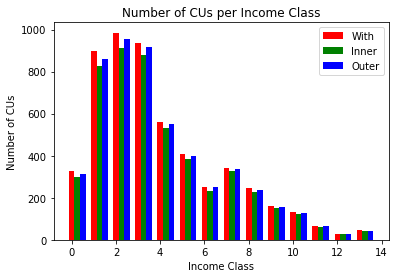

In [75]:
plt.close()
n_groups = 4
values1 = inclassExpenses.INCLASS.value_counts().values
values2 = clean1.INCLASS.value_counts().values
values3 = clean2.INCLASS.value_counts().values

fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.25
opacity = 1
 
rects1 = plt.bar(inclassExpenses.INCLASS.value_counts().index -1, values1, bar_width,
                 alpha=opacity,
                 color='r',
                 label='With')
 
rects2 = plt.bar(clean1.INCLASS.value_counts().index -1 + bar_width, values2, bar_width,
                 alpha=opacity,
                 color='g',
                 label='Inner')

rects3 = plt.bar(clean2.INCLASS.value_counts().index - 1 + bar_width*2, values3, bar_width,
                 alpha=opacity,
                 color='b',
                 label='Outer')

plt.xlabel('Income Class')
plt.ylabel('Number of CUs')
plt.title('Number of CUs per Income Class')
plt.legend()
plt.show()

The average percent change between with and without outliers: 2.02%


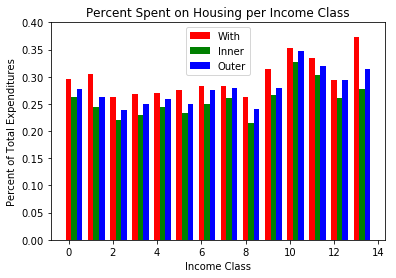

In [76]:
n_groups = 4
values1 = percentages.iHousing
values2 = cleanPercentages1.iHousing
values3 = cleanPercentages2.iHousing

print("The average percent change between with and without outliers: "+str(round((values1-values3).mean()*100,2))+"%")

fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.25
opacity = 1
 
rects1 = plt.bar(percentages.index, values1, bar_width,
                 alpha=opacity,
                 color='r',
                 label='With')
 
rects2 = plt.bar(cleanPercentages1.index + bar_width, values2, bar_width,
                 alpha=opacity,
                 color='g',
                 label='Inner')

rects3 = plt.bar(cleanPercentages2.index + bar_width*2, values3, bar_width,
                 alpha=opacity,
                 color='b',
                 label='Outer')

plt.xlabel('Income Class')
plt.ylabel('Percent of Total Expenditures')
plt.title('Percent Spent on Housing per Income Class')
plt.ylim(0,.4)
plt.legend()
plt.show()

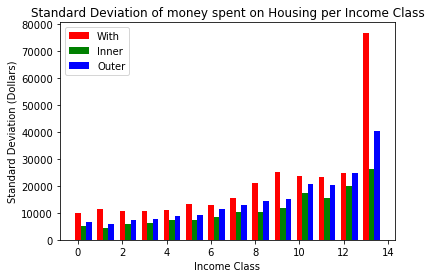

In [77]:
n_groups = 4
values1 = inclassSD.iHousing
values2 = inclassClean1SD.iHousing
values3 = inclassClean2SD.iHousing

fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.25
opacity = 1
 
rects1 = plt.bar(percentages.index, values1, bar_width,
                 alpha=opacity,
                 color='r',
                 label='With')
 
rects2 = plt.bar(cleanPercentages1.index + bar_width, values2, bar_width,
                 alpha=opacity,
                 color='g',
                 label='Inner')

rects3 = plt.bar(cleanPercentages2.index + bar_width*2, values3, bar_width,
                 alpha=opacity,
                 color='b',
                 label='Outer')

plt.xlabel('Income Class')
plt.ylabel('Standard Deviation (Dollars)')
plt.title('Standard Deviation of money spent on Housing per Income Class')
plt.legend()
plt.show()

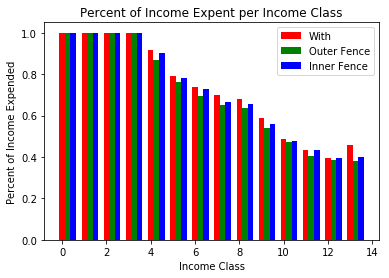

In [78]:
n_groups = 3
values1 = percentages.ExpInc
values2 = cleanPercentages1.ExpInc
values3 = cleanPercentages2.ExpInc

fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.25
opacity = 1
 
rects1 = plt.bar(percentages.index, values1, bar_width,
                 alpha=opacity,
                 color='r',
                 label='With')
 
rects2 = plt.bar(cleanPercentages1.index + bar_width, values2, bar_width,
                 alpha=opacity,
                 color='g',
                 label='Outer Fence')

rects3 = plt.bar(cleanPercentages2.index + bar_width*2, values3, bar_width,
                 alpha=opacity,
                 color='b',
                 label='Inner Fence')
 
plt.xlabel('Income Class')
plt.ylabel('Percent of Income Expended')
plt.title('Percent of Income Expent per Income Class')
plt.legend()
plt.show()

# Least squares polynomial fit
any value that would cause a person to expend over 100% of their income is truncated to 100%

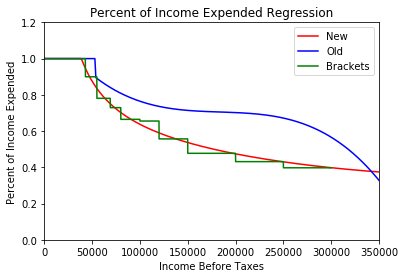

In [79]:
# cleanPercentages2.ExpInc[3:]
cleanReg = clean2[["FINCBTXM","iTotalExp"]]
cleanReg = cleanReg.loc[clean2.FINCBTXM > 0]
cleanReg = cleanReg.loc[cleanReg.iTotalExp > 0]
cleanReg
def getExpendPercent(income):
    if income <= 0:
        return(1)
    coefficients = np.polyfit(cleanReg.FINCBTXM, cleanReg.iTotalExp, deg = 3)
    p = np.poly1d(coefficients)
    np.seterr(divide='ignore')
    percent = p(income)/income
    if percent > 1:
        percent = 1
    return(percent)

x = range(0,360000,1000)
x2 = range(0,360000,1000)
y =[]
y2 =[]
def oldRegression(income):
    if income > 53000:
        output = ((-7.6108*(10**(-17)))*(income**3))+((4.2009*(10**(-11)))*(income**2))+((-7.90256*(10**-6))*income)+1.21112
    else:
        output = 1
    return(output)


for bracket in range(0,360000,1000):
    y.append(getExpendPercent(bracket))
    y2.append(oldRegression(bracket))
# plt.plot(inclassCleanAverages2.FINCBTXM,cleanPercentages2.ExpInc)
plt.plot(x,y, color = "r", label="New")
plt.plot(x2,y2, color = "b", label = "Old")
x3 = range(0,incomeBrackets[len(incomeBrackets)-2])

# creating the repeatArray for income Bracket plotting
lastvalue = 0
repeatArray = []
for x in range(0,len(incomeBrackets[1:len(incomeBrackets)-1])):
    repeatArray.append(incomeBrackets[1:len(incomeBrackets)-1][x] - lastvalue)
    lastvalue = incomeBrackets[1:len(incomeBrackets)-1][x]

y3 = np.repeat(cleanPercentages2.ExpInc[0:len(cleanPercentages2)-1], repeatArray)
plt.plot(x3,y3, color = "g", label = "Brackets")
plt.title("Percent of Income Expended Regression")
plt.xlabel("Income Before Taxes")
plt.ylabel("Percent of Income Expended")
plt.xlim(0,350000)
plt.ylim(0,1.2)
plt.legend()
plt.show()

# Examples of Users

In [80]:
usersIncome = [30000, 60000, 90000, 120000, 250000]
def getIncomeBracket(income):
    for bracket in range(len(incomeBrackets)-2,0,-1):
        if income > incomeBrackets[bracket]:
            return bracket
            

exampleExpenses = pd.DataFrame(columns = cleanPercentages2.columns, index = range(len(usersIncome)))
for user in usersIncome:
    userBracket = getIncomeBracket(user)
    userExpendAmount = getExpendPercent(user) * user
    userBaseExpenses = (cleanPercentages2.loc[userBracket]*userExpendAmount)/12
    exampleExpenses.loc[usersIncome.index(user)] = userBaseExpenses

exampleExpenses.index = usersIncome

exampleExpenses

,iFoodAtHome,iFoodAway,iHousing,iUtilites,iClothingAndBeauty,iTransportation,iHealthcare,iEntertainment,iMiscellaneous,iCharitableAndFamilyGiving,iInsurance,iEducation,iHousingPrinciple,ExpInc
30000,311.506,167.605,598.503,256.567,65.3051,377.361,429.101,145.049,34.4446,146.654,12.4094,7.02219,51.5271,2500
60000,452.178,264.252,1000.76,341.705,106.629,700.104,590.86,217.63,75.1721,326.368,37.2421,8.13196,113.724,3129.08
90000,519.884,323.206,1397.4,421.456,133.267,1060.57,658.58,239.852,92.1681,294.252,44.3029,20.6289,201.538,3326.55
120000,528.082,342.404,1422.74,424.994,178.126,1317.73,688.594,468.001,106.258,491.914,34.0358,76.154,178.407,3867.59
250000,697.714,527.181,2870.27,581.009,453.177,1867.98,666.583,555.958,206.05,700.551,91.8597,61.5549,315.727,3867.35


# Creating CSV fo percentages

In [81]:
# cleanPercentages2.to_csv("percentage65up.csv")

# Importing CSVs of pre-Subset Percentages CSVs

In [82]:
ageRange1 = pd.read_csv("percentage55to64.csv", index_col=0)
ageRange2 = pd.read_csv("percentage60up.csv", index_col=0)
ageRange3 = pd.read_csv("percentage65up.csv", index_col=0)

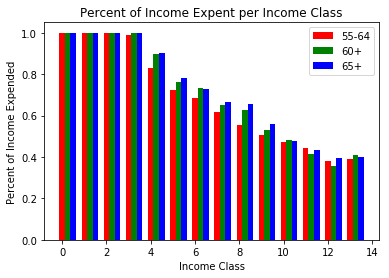

In [83]:
n_groups = 3
values1 = ageRange1.ExpInc
values2 = ageRange2.ExpInc
values3 = ageRange3.ExpInc

fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.25
opacity = 1
 
rects1 = plt.bar(ageRange1.index, values1, bar_width,
                 alpha=opacity,
                 color='r',
                 label='55-64')
 
rects2 = plt.bar(ageRange2.index + bar_width, values2, bar_width,
                 alpha=opacity,
                 color='g',
                 label='60+')

rects3 = plt.bar(ageRange3.index + (bar_width * 2), values3, bar_width,
                 alpha=opacity,
                 color='b',
                 label='65+')

plt.xlabel('Income Class')
plt.ylabel('Percent of Income Expended')
plt.title('Percent of Income Expent per Income Class')
plt.legend()
plt.show()

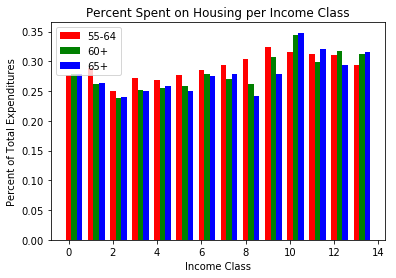

In [84]:
n_groups = 3
values1 = ageRange1.iHousing
values2 = ageRange2.iHousing
values3 = ageRange3.iHousing

fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.25
opacity = 1
 
rects1 = plt.bar(ageRange1.index, values1, bar_width,
                 alpha=opacity,
                 color='r',
                 label='55-64')
 
rects2 = plt.bar(ageRange2.index + bar_width, values2, bar_width,
                 alpha=opacity,
                 color='g',
                 label='60+')

rects3 = plt.bar(ageRange3.index + (bar_width * 2), values3, bar_width,
                 alpha=opacity,
                 color='b',
                 label='65+')

plt.xlabel('Income Class')
plt.ylabel('Percent of Total Expenditures')
plt.title('Percent Spent on Housing per Income Class')
plt.legend()
plt.show()

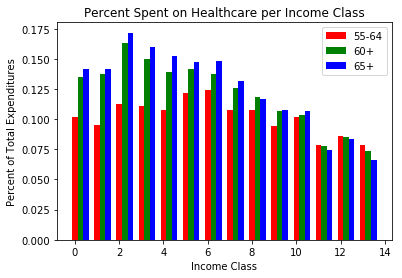

In [85]:
n_groups = 3
values1 = ageRange1.iHealthcare
values2 = ageRange2.iHealthcare
values3 = ageRange3.iHealthcare

fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.25
opacity = 1
 
rects1 = plt.bar(ageRange1.index, values1, bar_width,
                 alpha=opacity,
                 color='r',
                 label='55-64')
 
rects2 = plt.bar(ageRange2.index + bar_width, values2, bar_width,
                 alpha=opacity,
                 color='g',
                 label='60+')

rects3 = plt.bar(ageRange3.index + (bar_width * 2), values3, bar_width,
                 alpha=opacity,
                 color='b',
                 label='65+')

plt.xlabel('Income Class')
plt.ylabel('Percent of Total Expenditures')
plt.title('Percent Spent on Healthcare per Income Class')
plt.legend()
plt.show()

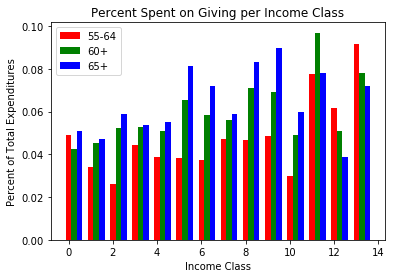

In [86]:
n_groups = 2
values1 = ageRange1.iCharitableAndFamilyGiving
values2 = ageRange2.iCharitableAndFamilyGiving
values3 = ageRange3.iCharitableAndFamilyGiving

fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.25
opacity = 1
 
rects1 = plt.bar(ageRange1.index, values1, bar_width,
                 alpha=opacity,
                 color='r',
                 label='55-64')
 
rects2 = plt.bar(ageRange2.index + bar_width, values2, bar_width,
                 alpha=opacity,
                 color='g',
                 label='60+')

rects3 = plt.bar(ageRange3.index + (bar_width * 2), values3, bar_width,
                 alpha=opacity,
                 color='b',
                 label='65+')

plt.xlabel('Income Class')
plt.ylabel('Percent of Total Expenditures')
plt.title('Percent Spent on Giving per Income Class')
plt.legend()
plt.show()

# Thoughts on the difference between 55-64 and 60+
- 60+ expend a higher percent of their income than 55-64 bracket
- This could be because the people in the 60+ bracket are actually retired meaning their income is lower?
 - should check this
- What are the advantages of using 60+ vs 55-64
 - doesn't just focus on the right at begining retirement age
 - better view of the retirement population
 - Higher expenditure percentages may be more realistic